H 1.0000000000000002


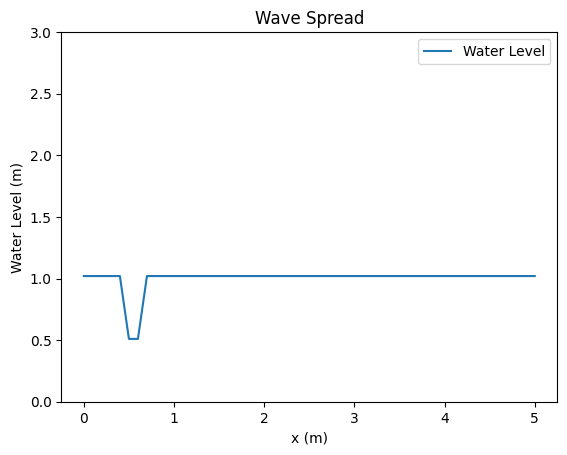

H 1.0000000000000002


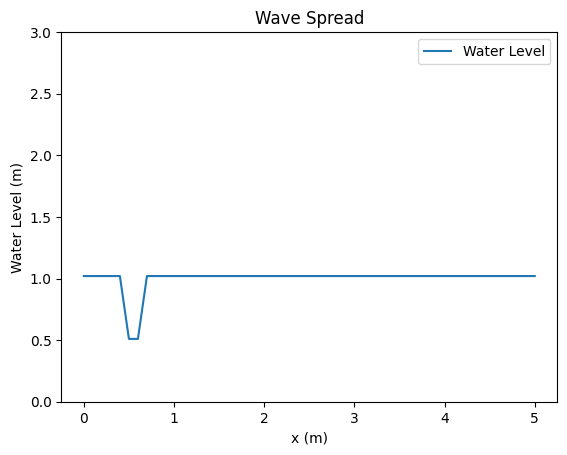

H 1.0000000000000002


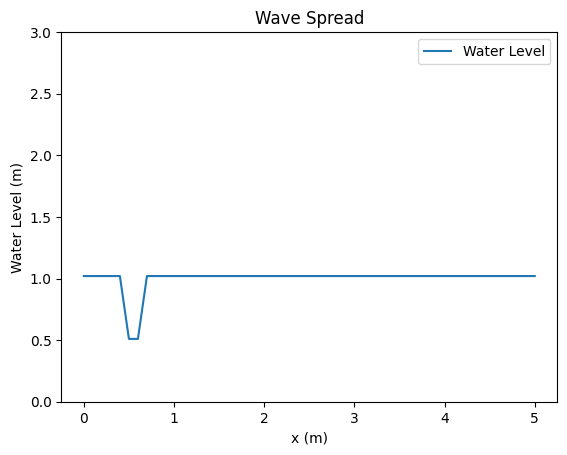

H 1.0000000000000002


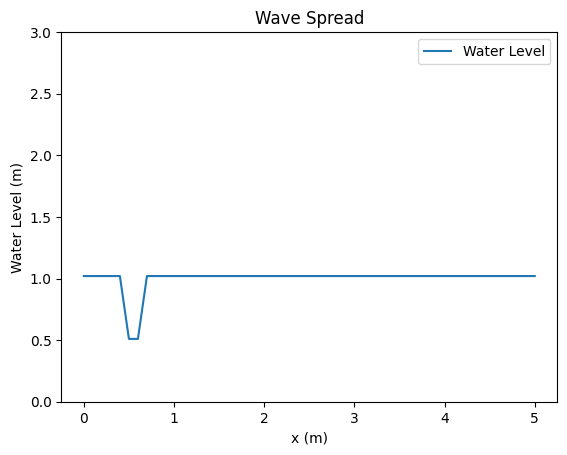

H 1.0000000000000002


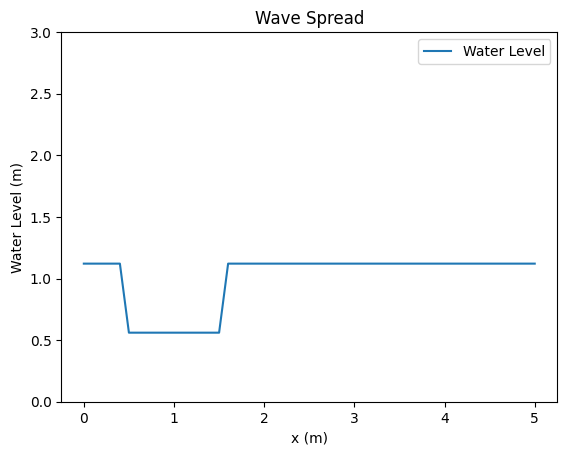

H 1.0000000000000002


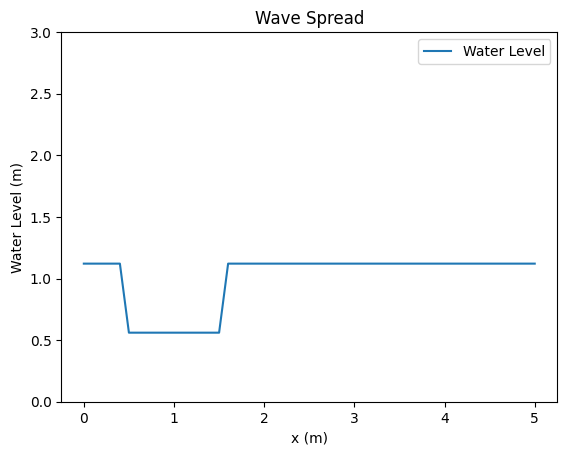

H 1.0000000000000002


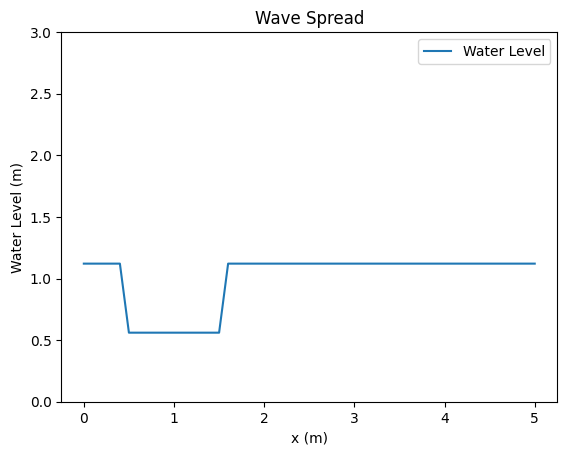

H 1.0000000000000002


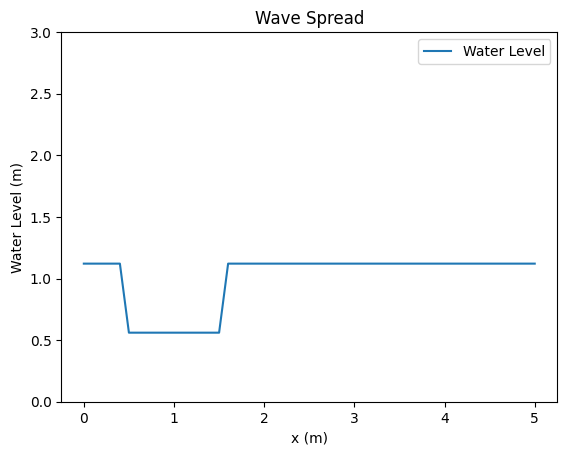

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

g = 9.81  
b = 1  
H = 1.0
dx = 0.1
dt = 0.0001
L = 5.0  
T = 10.0 

Nx = int(L / dx) + 1  
Nt = int(T / dt) + 1  
x = np.linspace(0, L, Nx)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for h_mode in range(2):
        for v_mode in range(4):
            
            # Начальные условия
            v = np.zeros((Nt, Nx)) 
            h = np.ones((Nt, Nx))  
            
            if h_mode == 0:
                h[0, Nx // 10: Nx //50*6 + 1] = 0.5
                s1 = "1"
            elif h_mode == 1:
                h[0, Nx // 10: Nx //50*15 + 1] = 0.5
                s1 = "2"
            h[0] /= np.sum(h[0])/len(h[0]) 
            print('H', np.sum(h[0])/len(h[0]))
            
            s2 = "1"
            if v_mode == 1:
                v[:, 0] = 1
                v[0, :] = ((5-x)/5)**10 - (x/5)**10
                v[:, -1] = -1
                s2 = "2"
            elif v_mode == 2:
                v[:, 0] = 1
                v[0, :] = ((5-x)/5)**10
                v[:, -1] = 0
                s2 = "3"
            elif v_mode == 3:
                v[:, 0] = 0
                v[0, :] = - (x/5)**10
                v[:, -1] = -1
                s2 = "4"

            for n in range(Nt - 1):
                for i in range(1, Nx - 1):  
                    dh_dx = (h[n, i] - h[n, i - 1]) / dx
                    dv_dx = (v[n, i + 1] - v[n, i]) / dx
                    dh_dx_center = (h[n, i + 1] - h[n, i - 1]) / (2 * dx)

                    v[n + 1, i] = v[n, i] + dt * (-g * dh_dx - b * v[n, i])

                    h[n + 1, i] = h[n, i] - dt * (H + h[n, i]) * dv_dx + dt * v[n, i] * dh_dx_center



            # Анимация
            fig, ax = plt.subplots()
            line, = ax.plot(x, h[0, :], label="Water Level")
            ax.set_ylim(0, 3)
            ax.set_title("Wave Spread")
            ax.set_xlabel("x (m)")
            ax.set_ylabel("Water Level (m)")
            ax.legend()

            def update(frame):
                line.set_xdata(x)
                line.set_ydata(h[frame*100, :]) 
                return line,

            ani = FuncAnimation(fig, update, frames=Nt//100, interval=50, blit=True)
            plt.show()
            ani.save("explicit_" + s1 + "_" + s2 +".mp4")


10.0
H 1.0000000000000002
H 1.0000000000000002


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:59: RuntimeWarning: invalid 

H 1.0000000000000002


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: overflow

H 1.0000000000000002


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:59: RuntimeWarning: invalid 

H 0.9999999999999999
H 0.9999999999999999


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:59: RuntimeWarning: invalid 

H 0.9999999999999999


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: overflow encountered in scalar divide
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value e

H 0.9999999999999999


C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: overflow encountered in scalar multiply
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar add
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
C:\Users\HP\AppData\Local\Temp\ipykernel_12024\3437400299.py:59: RuntimeWarning: invalid 

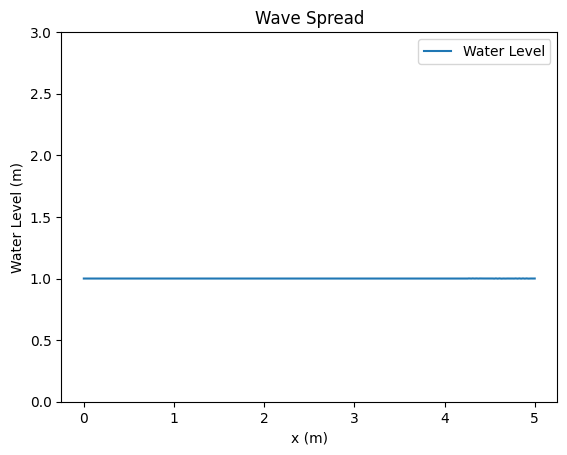

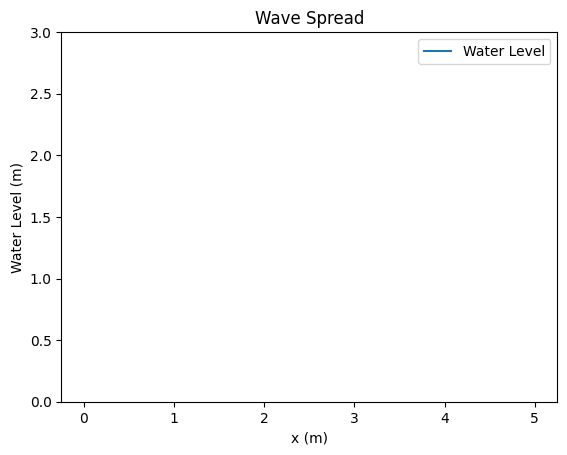

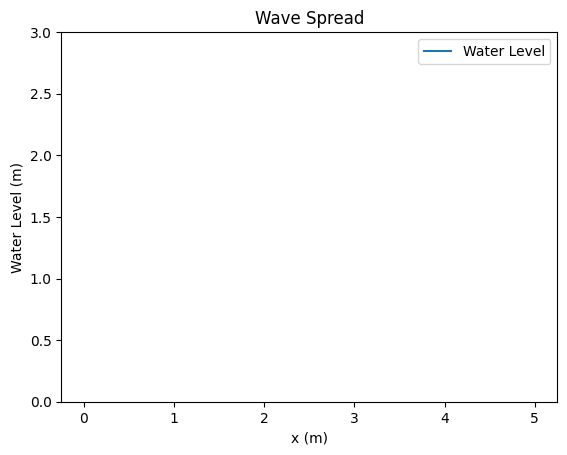

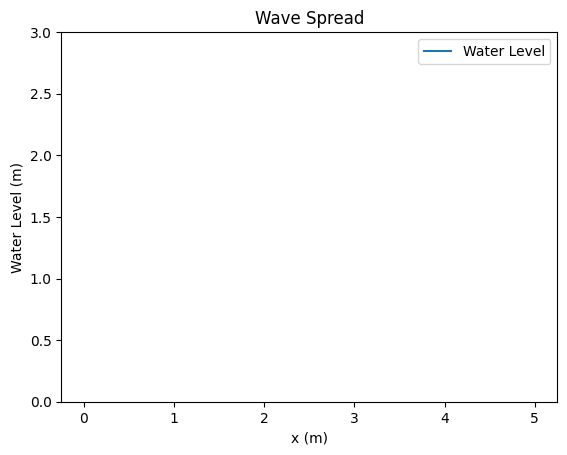

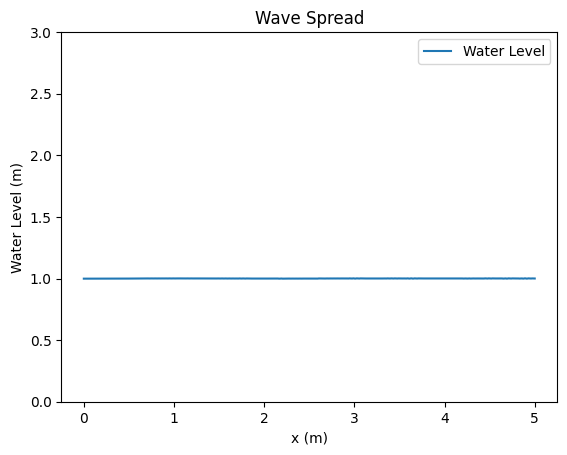

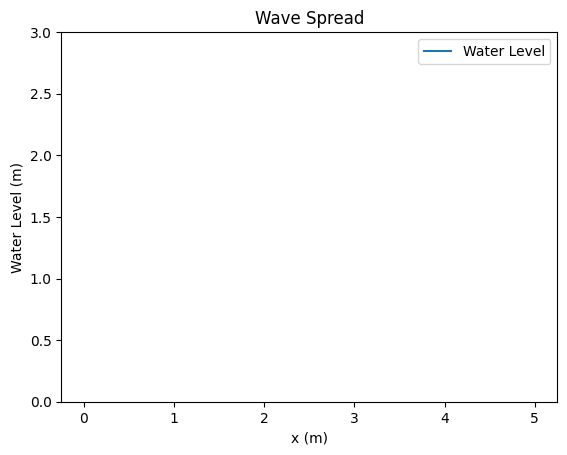

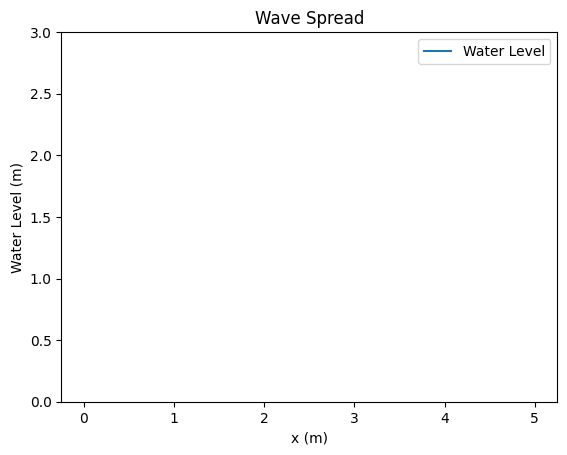

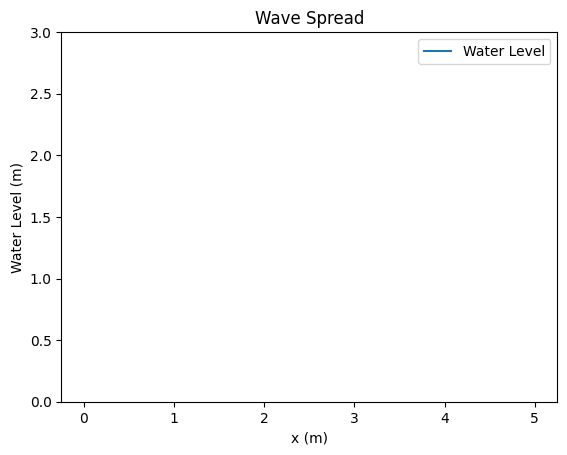

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import time

x_pts = 500
dt = 0.001
dx = 5/x_pts
g = 10
b = 1 
H = 1

print(dx/dt)
for h_mode in range(2):
    for v_mode in range(4):
        
        h = np.ones(x_pts)
        start = x_pts//10           # 0.5
        if h_mode == 0:
            s1 = "1"
            end = x_pts//10 + x_pts//50 # 0.6
        else:
            s1 = "2"
            end = x_pts//10 + x_pts//5  # 1.5
        for i in np.arange(start, end):
            h[i] -= 0.5
        
        u = np.zeros_like(h)
        for i in np.arange(len(u)):
            x = i*dx
            if v_mode == 1:
                u[i] = ((5-x)/5)**10 - (x/5)**10
            elif v_mode == 2:
                u[i] = ((5-x)/5)**10
            elif v_mode == 3:
                u[i] = - (x/5)**10

        phi_u_left = 0
        phi_u_right = 0
        s2 = "1"
        if v_mode == 1:
            s2 = "2"
            phi_u_left = 1        
            phi_u_right = -1
        elif v_mode == 2:
            s2 = "3"
            phi_u_left = 1        
        elif v_mode == 3:
            s2 = "4"
            phi_u_right = -1
        
        h /= np.sum(h)/len(h) 
        print('H', np.sum(h)/len(h))

        def solve(phi_u, phi_h, u0, h0, eps):
            u = [f(u0, h0) for f in phi_u]
            h = [f(u0, h0) for f in phi_h]
            c = 0
            while np.max(np.abs(np.concatenate((u, h)) -
                                np.concatenate((u0, h0)))) >= eps:
                c += 1
                u0 = u
                h0 = h
                u = [f(u0, h0) for f in phi_u]
                h = [f(u0, h0) for f in phi_h]
            # print('system solved in', c, 'iterations')
            return u, h

        def make_phis(u_prev, h_prev):
            phi_u = [None]
            for i in np.arange(1, len(u)-1):
                phi_u += [lambda u, h, i=i: u_prev[i] - dt*(g*(h[i+1] - h[i-1])/(2*dx) + b*u[i])]
            phi_u[0] = lambda u, h: phi_u_left
            phi_u += [lambda u, h: phi_u_right]

            phi_h = [None]
            for i in np.arange(1, len(h)-1):
                phi_h += [lambda u, h, i=i: h_prev[i] - (dt/(2*dx))*((H + h[i])*(u[i+1] - u[i-1]) + u[i]*(h[i+1] - h[i-1]))]
            phi_h[0] = phi_h[1]
            phi_h += [phi_h[len(phi_h)-1]]

            return phi_u, phi_h

        def next_inexact(u, h):
            return solve(*make_phis(u, h), u, h, 0.001)

        x_mas = np.linspace(0, 5, x_pts, endpoint=True)
        fig, ax = plt.subplots()
        line, = ax.plot(x_mas, h, label="Water Level")
        ax.set_ylim(0, 3)
        ax.set_title("Wave Spread")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("Water Level (m)")
        ax.legend()

        def update(frame_number):
            global h, u, H
            for i in range(10):
                u, h = next_inexact(u, h)
            u, h = next_inexact(u, h)
            line.set_ydata(h)
            return line,

        animation = FuncAnimation(fig, update, frames=1000, interval=50, blit = True)
        
        
        animation.save("implicit_" + s1 + "_" + s2 +".mp4")
        